In [1]:
%%capture
!pip install deepchem transformers peft

In [2]:
import warnings
import logging

warnings.filterwarnings("ignore", category=DeprecationWarning)
logging.getLogger("deepchem").setLevel(logging.ERROR)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import deepchem as dc
from peft import get_peft_model, LoraConfig, TaskType
import time
from sklearn.metrics import accuracy_score
from rdkit import Chem
import matplotlib.pyplot as plt
import numpy as np

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [4]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: tg2933 (hpml-proj-deepchem) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [5]:
# Define paths and parameters
MODEL_NAME = "seyonec/ChemBERTa-zinc-base-v1"
MAX_LENGTH = 128
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 3e-4

# LoRA Configuration
LORA_R = 8  # Rank of LoRA
LORA_ALPHA = 16
LORA_DROPOUT = 0.1

In [6]:
class ClinToxDataset(Dataset):
    def __init__(self, data_path, tokenizer, split='train', max_length=128):
        """
        Custom PyTorch Dataset for the ClinTox dataset.
        """
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.split = split

        # Load ClinTox dataset from DeepChem
        tasks, datasets, transformers = dc.molnet.load_clintox()
        train_dataset, valid_dataset, test_dataset = datasets

        # Convert to SMILES and labels
        self.smiles_train, self.labels_train = self.remove_invalid_smiles(train_dataset.ids, train_dataset.y)
        self.smiles_valid, self.labels_valid = self.remove_invalid_smiles(valid_dataset.ids, valid_dataset.y)
        self.smiles_test, self.labels_test = self.remove_invalid_smiles(test_dataset.ids, test_dataset.y)

        # Set active split
        if split == 'train':
            self.smiles = self.smiles_train
            self.labels = self.labels_train
        elif split == 'valid':
            self.smiles = self.smiles_valid
            self.labels = self.labels_valid
        elif split == 'test':
            self.smiles = self.smiles_test
            self.labels = self.labels_test
        else:
            raise ValueError("Invalid split. Use 'train', 'valid', or 'test'.")

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        smiles = self.smiles[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            smiles,
            return_tensors="pt",
            max_length=self.max_length,
            padding="max_length",
            truncation=True
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.float)
        }

    def remove_invalid_smiles(self, smiles, labels):
        """
        Filters out invalid SMILES strings using RDKit validation.
        """
        valid_indices = []
        for i, smile in enumerate(smiles):
            try:
                mol = Chem.MolFromSmiles(smile)
                if mol is not None:
                    valid_indices.append(i)
            except:
                pass

        return smiles[valid_indices], labels[valid_indices]

In [7]:
def setup_lora_model(model_name):
    """
    Set up a model with LoRA configuration
    """
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2,  # Binary classification for ClinTox
        return_dict=True
    )

    peft_config = LoraConfig(
        task_type=TaskType.SEQ_CLS,
        inference_mode=False,
        r=LORA_R,
        lora_alpha=LORA_ALPHA,
        lora_dropout=LORA_DROPOUT,
        target_modules=["query", "value"]  # Target attention modules
    )

    model = get_peft_model(model, peft_config)
    return model

In [8]:
def evaluate_model(model, dataloader, device):
    """
    Evaluate the model on the validation or test set.
    """
    model.eval()
    total_loss = 0
    all_labels = []
    all_preds = []
    criterion = nn.BCEWithLogitsLoss()

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            loss = criterion(logits, labels)
            total_loss += loss.item()

            probs = torch.sigmoid(logits)
            all_preds.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Binary predictions for accuracy
    bin_preds = (all_preds > 0.5).astype(int)
    accuracy = accuracy_score(all_labels, bin_preds)

    avg_loss = total_loss / len(dataloader)
    return avg_loss, accuracy

In [9]:
def train_and_profile(model, tokenizer, optimization_name):
    """
    Train and evaluate a model with comprehensive logging to Weights & Biases
    """

    wandb.init(
        project="testing",
        entity="hpml-proj-deepchem",
        name=optimization_name,
        config={
            "model_name": MODEL_NAME,
            "batch_size": BATCH_SIZE,
            "epochs": EPOCHS,
            "learning_rate": LEARNING_RATE,
            "lora_r": LORA_R,
            "lora_alpha": LORA_ALPHA,
            "lora_dropout": LORA_DROPOUT,
            "optimization": optimization_name
        }
    )

    # Create datasets for each split
    train_dataset = ClinToxDataset("clintox", tokenizer, split="train", max_length=MAX_LENGTH)
    val_dataset = ClinToxDataset("clintox", tokenizer, split="valid", max_length=MAX_LENGTH)
    test_dataset = ClinToxDataset("clintox", tokenizer, split="test", max_length=MAX_LENGTH)

    # Create dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.BCEWithLogitsLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses, val_losses, val_accuracies, epoch_times = [], [], [], []

    print(f"\n--- {optimization_name} ---")

    torch.cuda.reset_peak_memory_stats(device)

    start_time = time.time()
    total_samples = 0

    for epoch in range(EPOCHS):
        epoch_start_time = time.time()
        model.train()
        total_train_loss = 0
        progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{EPOCHS}")

        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            loss = criterion(logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_samples += input_ids.size(0)
            total_train_loss += loss.item()
            progress_bar.set_postfix({"loss": loss.item()})

        epoch_time = time.time() - epoch_start_time
        avg_train_loss = total_train_loss / len(train_dataloader)
        val_loss, val_acc = evaluate_model(model, val_dataloader, device)

        train_losses.append(avg_train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        epoch_times.append(epoch_time)

        print(f"Epoch {epoch+1} | Training Time: {epoch_time:.2f}s | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {val_acc:.4f}")

    end_time = time.time()
    total_train_time = end_time - start_time
    throughput = total_samples / total_train_time
    peak_memory_MB = torch.cuda.max_memory_allocated(device) / (1024 ** 2) if torch.cuda.is_available() else 0

    test_loss, test_acc = evaluate_model(model, test_dataloader, device)

    wandb.log({
        "test_loss": test_loss,
        "test_accuracy": test_acc,
        "training_time": total_train_time,
        "throughput": throughput,
        "peak_gpu_memory": peak_memory_MB
    })

    fig, ax = plt.subplots(figsize=(10, 6))
    epochs = list(range(1, EPOCHS + 1))
    ax.plot(epochs, train_losses, label='Training Loss')
    ax.plot(epochs, val_losses, label='Validation Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training/Validation Loss - {optimization_name}')
    ax.legend()
    ax.grid(True)

    second_run = wandb.init(project="testing", entity="hpml-proj-deepchem", name=f"{optimization_name}_loss_curves")
    wandb.log({f"{optimization_name}_loss_curves": wandb.Image(fig)})
    wandb.finish()

    # Create and log accuracy curve
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(epochs, val_accuracies, label='Validation Accuracy', color='green')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_title(f'Validation Accuracy - {optimization_name}')
    ax.legend()
    ax.grid(True)

    third_run = wandb.init(project="testing", entity="hpml-proj-deepchem", name=f"{optimization_name}_accuracy_curves")
    wandb.log({f"{optimization_name}_accuracy_curves": wandb.Image(fig)})
    wandb.finish()

    # Create and log accuracy curve
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(epochs, epoch_times, label='Epoch Train Time', color='green')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Training Time (s)')
    ax.set_title(f'Epoch Training Times - {optimization_name}')
    ax.legend()
    ax.grid(True)

    fourth_run = wandb.init(project="testing", entity="hpml-proj-deepchem", name=f"{optimization_name}_epoch_times")
    wandb.log({f"{optimization_name}_epoch_times": wandb.Image(fig)})
    wandb.finish()


    print(f"\n--- {optimization_name} ---")
    print(f"Total Training Time: {total_train_time:.2f} seconds")
    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")
    print(f"Throughput: {throughput:.2f} samples/sec")
    print(f"Peak GPU Memory Usage: {peak_memory_MB:.2f} MB")


    return {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies,
        "epoch_times": epoch_times,
        "training_time": total_train_time,
        "test_accuracy": test_acc,
        "throughput": throughput,
        "peak_memory_usage": peak_memory_MB}

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/166 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/501 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/9.43k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/3.21k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/179M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/179M [00:00<?, ?B/s]

[23:20:28] DEPRECATION WARNING: please use MorganGenerator
[23:20:28] DEPRECATION WARNING: please use MorganGenerator
[23:20:28] DEPRECATION WARNING: please use MorganGenerator
[23:20:28] DEPRECATION WARNING: please use MorganGenerator
[23:20:28] DEPRECATION WARNING: please use MorganGenerator
[23:20:28] DEPRECATION WARNING: please use MorganGenerator
[23:20:28] DEPRECATION WARNING: please use MorganGenerator
[23:20:28] Explicit valence for atom # 0 N, 5, is greater than permitted
[23:20:28] DEPRECATION WARNING: please use MorganGenerator
[23:20:28] DEPRECATION WARNING: please use MorganGenerator
[23:20:28] DEPRECATION WARNING: please use MorganGenerator
[23:20:28] DEPRECATION WARNING: please use MorganGenerator
[23:20:28] DEPRECATION WARNING: please use MorganGenerator
[23:20:28] DEPRECATION WARNING: please use MorganGenerator
[23:20:28] DEPRECATION WARNING: please use MorganGenerator
[23:20:28] DEPRECATION WARNING: please use MorganGenerator
[23:20:28] DEPRECATION WARNING: please use


--- Baseline ---



Evaluating: 100%|██████████| 5/5 [00:00<00:00, 29.22it/s]


Epoch 1 | Training Time: 3.33s | Train Loss: 0.1769 | Val Loss: 0.0998 | Val Accuracy: 0.9595


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 28.77it/s]


Epoch 2 | Training Time: 2.34s | Train Loss: 0.0730 | Val Loss: 0.0968 | Val Accuracy: 0.9730


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 29.41it/s]


Epoch 3 | Training Time: 2.32s | Train Loss: 0.0820 | Val Loss: 0.0732 | Val Accuracy: 0.9797


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 28.46it/s]


Epoch 4 | Training Time: 2.33s | Train Loss: 0.0477 | Val Loss: 0.0850 | Val Accuracy: 0.9730


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 29.55it/s]


Epoch 5 | Training Time: 2.34s | Train Loss: 0.0436 | Val Loss: 0.0952 | Val Accuracy: 0.9662


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 29.61it/s]


Epoch 6 | Training Time: 2.33s | Train Loss: 0.0293 | Val Loss: 0.1219 | Val Accuracy: 0.9595


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 29.70it/s]


Epoch 7 | Training Time: 2.33s | Train Loss: 0.0282 | Val Loss: 0.1538 | Val Accuracy: 0.9189


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 29.71it/s]


Epoch 8 | Training Time: 2.32s | Train Loss: 0.0277 | Val Loss: 0.1028 | Val Accuracy: 0.9662


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 29.07it/s]


Epoch 9 | Training Time: 2.34s | Train Loss: 0.0248 | Val Loss: 0.1157 | Val Accuracy: 0.9459


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 28.85it/s]


Epoch 10 | Training Time: 2.34s | Train Loss: 0.0186 | Val Loss: 0.0854 | Val Accuracy: 0.9730


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 30.65it/s]


peak_gpu_memory,▁
test_accuracy,▁
test_loss,▁
throughput,▁
training_time,▁
peak_gpu_memory,1239.98145
test_accuracy,0.98649
test_loss,0.06173
throughput,453.93731
training_time,26.0829



--- Baseline ---
Total Training Time: 26.08 seconds
Test Loss: 0.0617 | Test Accuracy: 0.9865
Throughput: 453.94 samples/sec
Peak GPU Memory Usage: 1239.98 MB


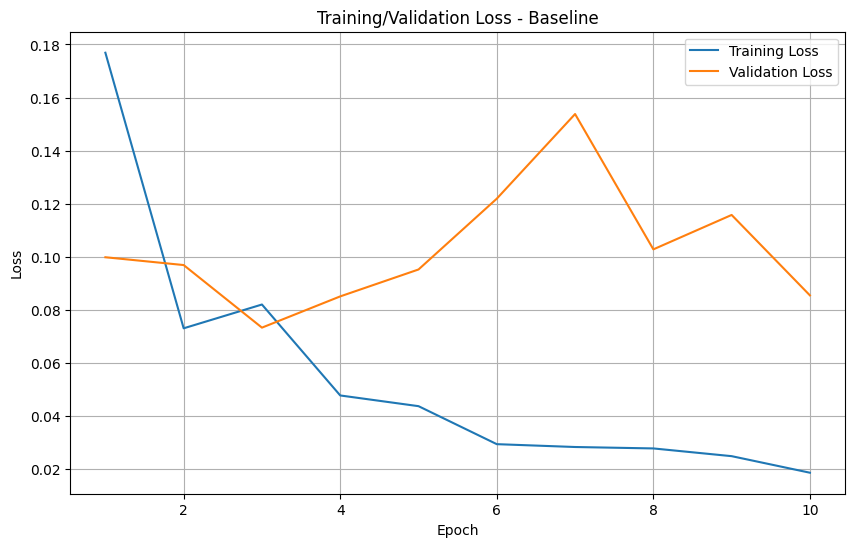

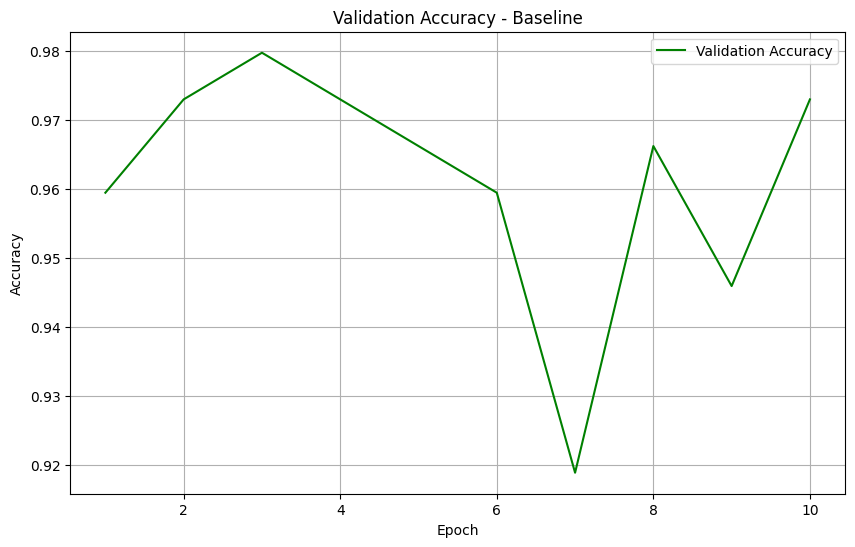

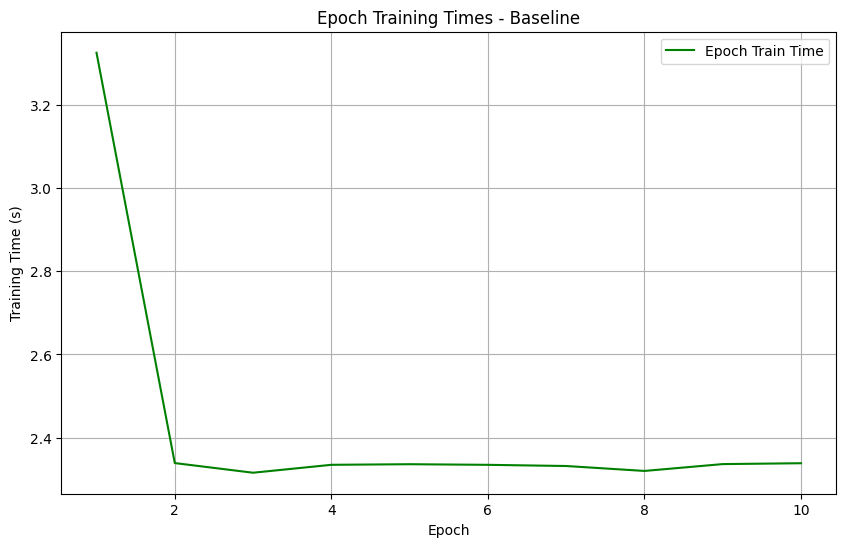

In [10]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = setup_lora_model(MODEL_NAME)

baseline_metrics = train_and_profile(model, tokenizer, "Baseline")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Torch.Compile ---


Epoch 1/10:   0%|          | 0/37 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/_inductor/compile_fx.py:194: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(
Evaluating: 100%|██████████| 5/5 [00:22<00:00,  4.42s/it]


Epoch 1 | Training Time: 27.78s | Train Loss: 0.2055 | Val Loss: 0.0966 | Val Accuracy: 0.9662


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 29.57it/s]


Epoch 2 | Training Time: 2.28s | Train Loss: 0.0795 | Val Loss: 0.0871 | Val Accuracy: 0.9730


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 29.83it/s]


Epoch 3 | Training Time: 2.28s | Train Loss: 0.0587 | Val Loss: 0.0820 | Val Accuracy: 0.9797


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 29.74it/s]


Epoch 4 | Training Time: 2.27s | Train Loss: 0.0513 | Val Loss: 0.1091 | Val Accuracy: 0.9662


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 29.35it/s]


Epoch 5 | Training Time: 2.31s | Train Loss: 0.0424 | Val Loss: 0.0941 | Val Accuracy: 0.9662


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 29.91it/s]


Epoch 6 | Training Time: 2.29s | Train Loss: 0.0336 | Val Loss: 0.1362 | Val Accuracy: 0.9459


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 29.76it/s]


Epoch 7 | Training Time: 2.29s | Train Loss: 0.0227 | Val Loss: 0.0862 | Val Accuracy: 0.9662


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 29.28it/s]


Epoch 8 | Training Time: 2.31s | Train Loss: 0.0238 | Val Loss: 0.1349 | Val Accuracy: 0.9662


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 29.60it/s]


Epoch 9 | Training Time: 2.28s | Train Loss: 0.0233 | Val Loss: 0.0764 | Val Accuracy: 0.9865


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 29.25it/s]


Epoch 10 | Training Time: 2.31s | Train Loss: 0.0279 | Val Loss: 0.0757 | Val Accuracy: 0.9797


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 30.81it/s]


peak_gpu_memory,▁
test_accuracy,▁
test_loss,▁
throughput,▁
training_time,▁
peak_gpu_memory,1494.97021
test_accuracy,0.98649
test_loss,0.06591
throughput,164.34009
training_time,72.04572



--- Torch.Compile ---
Total Training Time: 72.05 seconds
Test Loss: 0.0659 | Test Accuracy: 0.9865
Throughput: 164.34 samples/sec
Peak GPU Memory Usage: 1494.97 MB


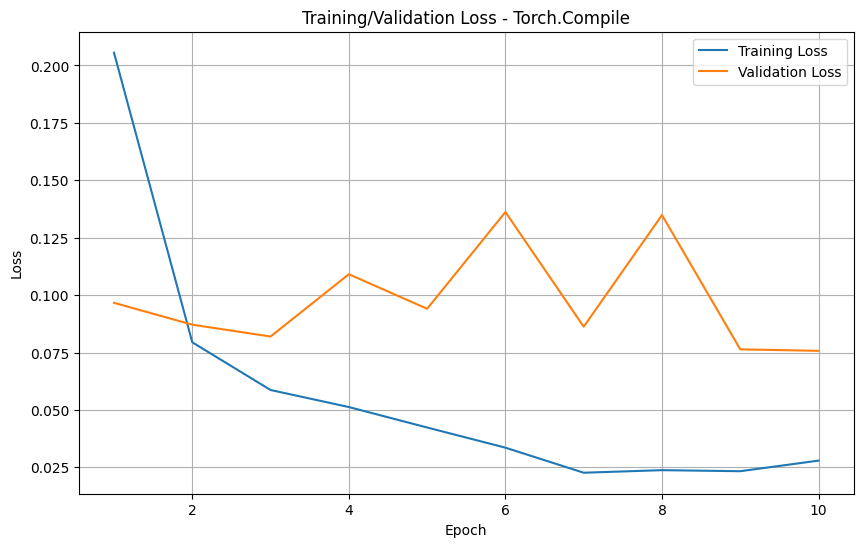

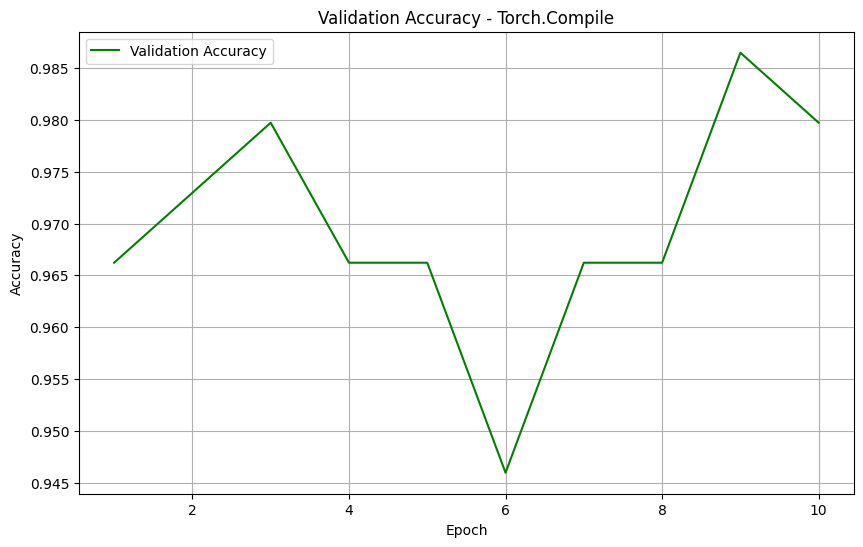

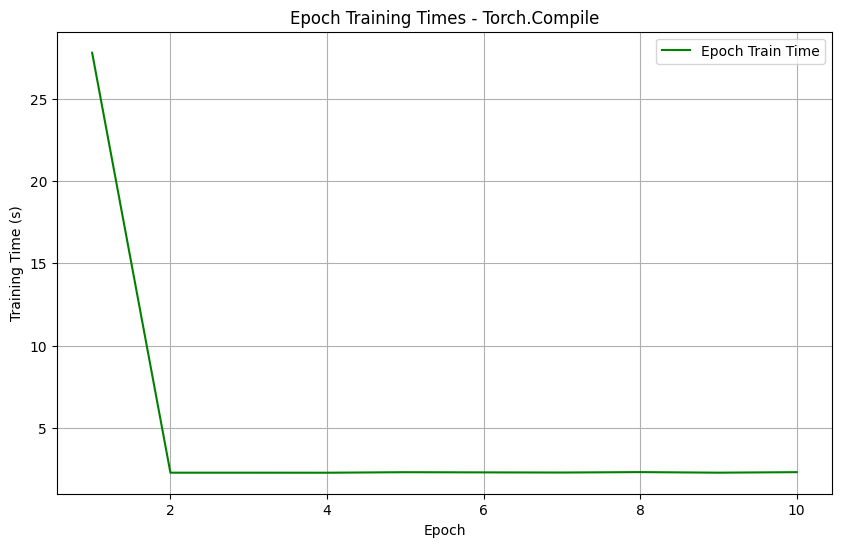

In [11]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = setup_lora_model(MODEL_NAME)

compiled_model = torch.compile(model)

torch_compile_metrics = train_and_profile(compiled_model, tokenizer, "Torch.Compile")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Torch.Compile Reduce-Overhead Mode ---


Evaluating: 100%|██████████| 5/5 [00:12<00:00,  2.55s/it]


Epoch 1 | Training Time: 29.51s | Train Loss: 0.1973 | Val Loss: 0.0962 | Val Accuracy: 0.9730


Evaluating: 100%|██████████| 5/5 [00:00<00:00,  5.60it/s]


Epoch 2 | Training Time: 2.28s | Train Loss: 0.0899 | Val Loss: 0.0880 | Val Accuracy: 0.9730


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 30.23it/s]


Epoch 3 | Training Time: 2.26s | Train Loss: 0.0583 | Val Loss: 0.0814 | Val Accuracy: 0.9662


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 29.39it/s]


Epoch 4 | Training Time: 2.26s | Train Loss: 0.0478 | Val Loss: 0.0759 | Val Accuracy: 0.9797


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 30.07it/s]


Epoch 5 | Training Time: 2.29s | Train Loss: 0.0437 | Val Loss: 0.1119 | Val Accuracy: 0.9459


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 29.51it/s]


Epoch 6 | Training Time: 2.26s | Train Loss: 0.0354 | Val Loss: 0.0854 | Val Accuracy: 0.9662


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 30.23it/s]


Epoch 7 | Training Time: 2.28s | Train Loss: 0.0284 | Val Loss: 0.0777 | Val Accuracy: 0.9797


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 29.80it/s]


Epoch 8 | Training Time: 2.26s | Train Loss: 0.0288 | Val Loss: 0.0783 | Val Accuracy: 0.9730


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 29.65it/s]


Epoch 9 | Training Time: 2.27s | Train Loss: 0.0240 | Val Loss: 0.1309 | Val Accuracy: 0.9459


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 29.74it/s]


Epoch 10 | Training Time: 2.28s | Train Loss: 0.0195 | Val Loss: 0.1236 | Val Accuracy: 0.9392


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 30.99it/s]


peak_gpu_memory,▁
test_accuracy,▁
test_loss,▁
throughput,▁
training_time,▁
peak_gpu_memory,1671.99805
test_accuracy,0.98649
test_loss,0.06563
throughput,182.11447
training_time,65.01406



--- Torch.Compile Reduce-Overhead Mode ---
Total Training Time: 65.01 seconds
Test Loss: 0.0656 | Test Accuracy: 0.9865
Throughput: 182.11 samples/sec
Peak GPU Memory Usage: 1672.00 MB


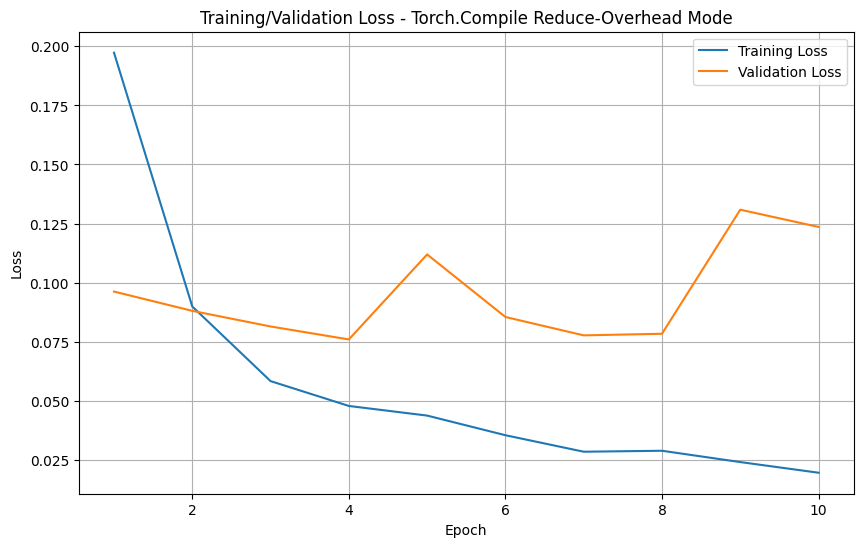

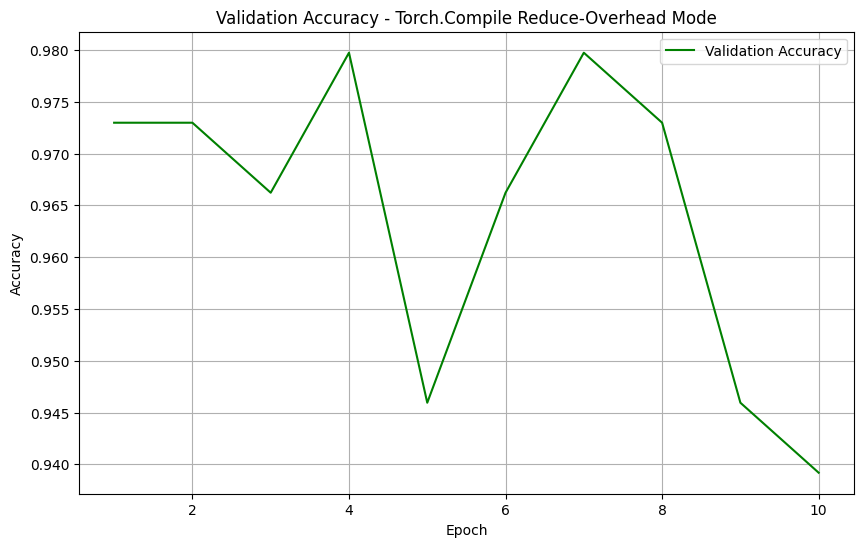

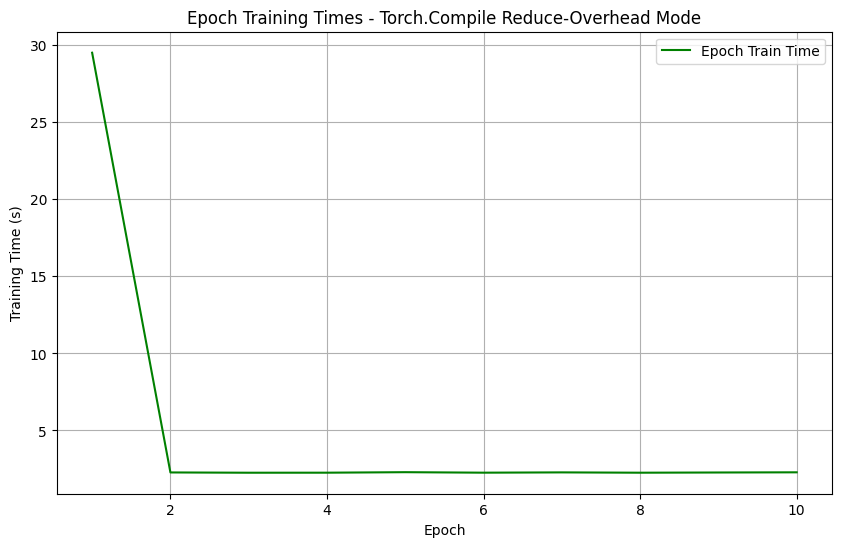

In [12]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = setup_lora_model(MODEL_NAME)

compiled_overhead_model = torch.compile(model, mode = "reduce-overhead")

compile_overhead_metrics = train_and_profile(compiled_overhead_model, tokenizer, "Torch.Compile Reduce-Overhead Mode")

In [13]:
def plot_metrics(baseline_metrics, torch_compile_metrics, compile_overhead_metrics):
    """
    Log a bar chart comparing training time, test accuracy, throughputs, and peak memory usages for all models.
    """

    models = ["Baseline", "Torch.Compile", "Torch.Compile\nReduce-Overhead\nMode"]

    training_times = [baseline_metrics["training_time"], torch_compile_metrics["training_time"], compile_overhead_metrics["training_time"]]
    test_accuracies = [baseline_metrics["test_accuracy"], torch_compile_metrics["test_accuracy"], compile_overhead_metrics["test_accuracy"]]
    throughputs = [baseline_metrics["throughput"], torch_compile_metrics["throughput"], compile_overhead_metrics["throughput"]]
    peak_memory_usages = [baseline_metrics["peak_memory_usage"], torch_compile_metrics["peak_memory_usage"], compile_overhead_metrics["peak_memory_usage"]]


    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    axs = axs.flatten()
    axs[0].bar(models, training_times, color=["blue", "green", "red"])
    axs[0].set_title("Training Times")
    axs[0].set_ylabel("Seconds")
    #axs[0].set_xticklabels(models, rotation=45)

    axs[1].bar(models, test_accuracies, color=["blue", "green", "red"])
    axs[1].set_title("Test Accuracies")
    axs[1].set_ylabel("Accuracy")

    axs[2].bar(models, throughputs, color=["blue", "green", "red"])
    axs[2].set_title("Throughput")
    axs[2].set_ylabel("Samples/sec")

    axs[3].bar(models, peak_memory_usages, color=["blue", "green", "red"])
    axs[3].set_title("Peak GPU Memory Usage")
    axs[3].set_ylabel("MB")

    plt.tight_layout()



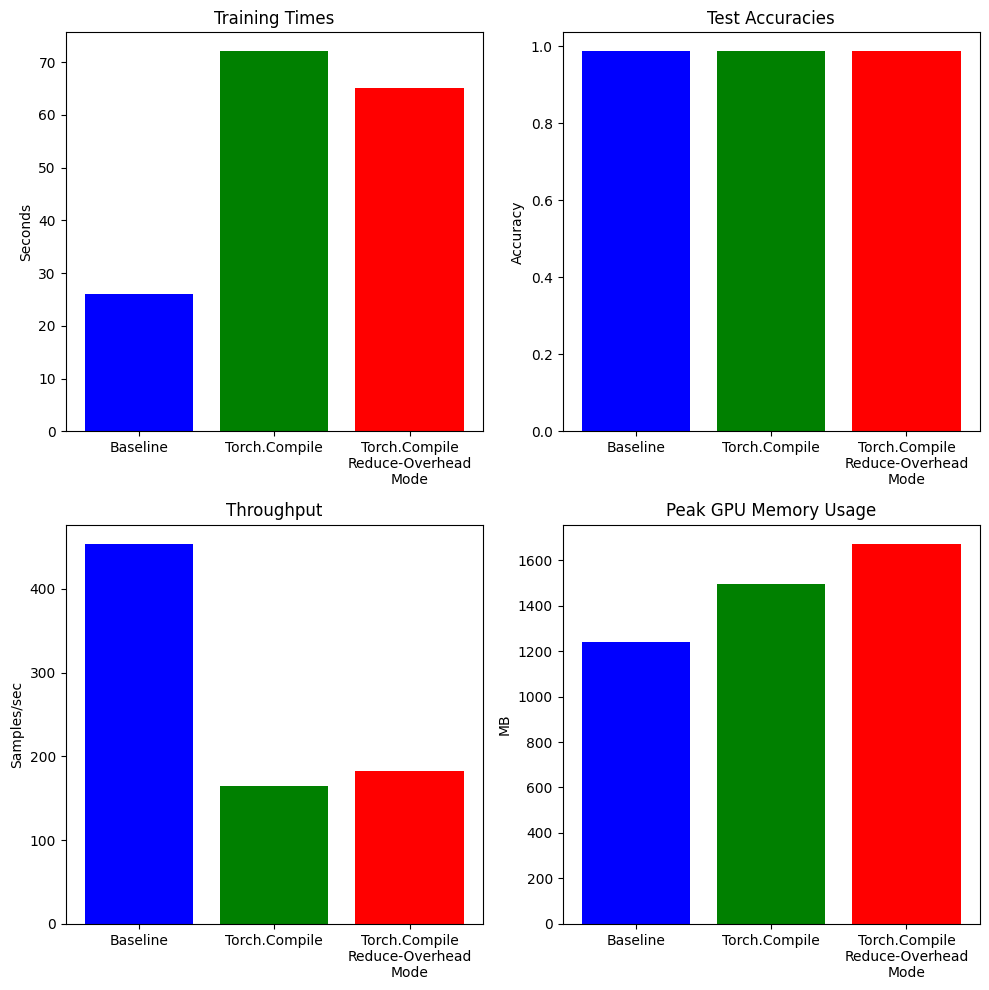

In [14]:
plot_metrics(baseline_metrics, torch_compile_metrics, compile_overhead_metrics)

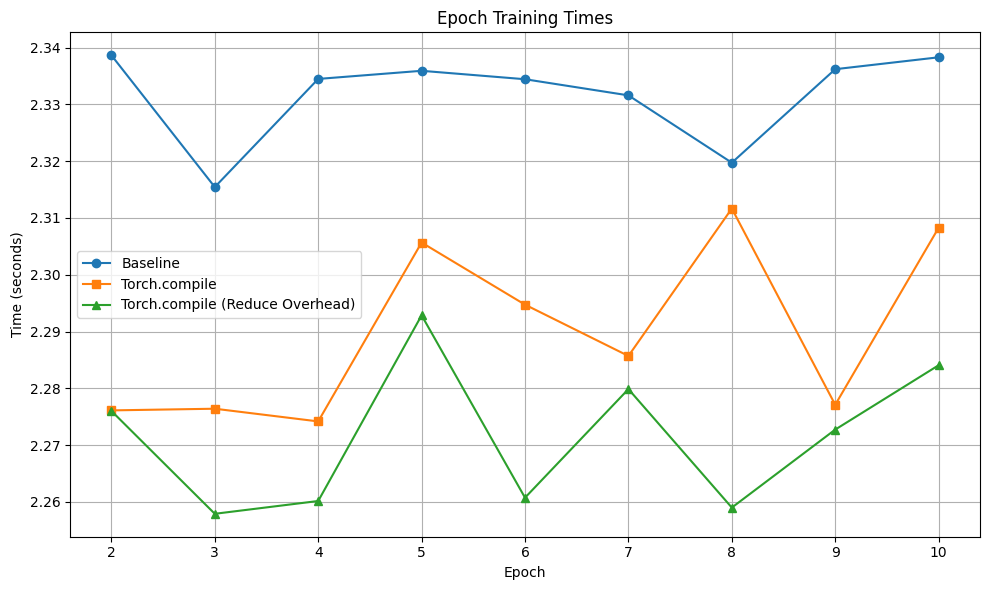

In [20]:
def plot_epoch_times(baseline_metrics, torch_compile_metrics, compile_overhead_metrics):
    baseline_times = baseline_metrics["epoch_times"]
    torch_compile_times = torch_compile_metrics["epoch_times"]
    compile_overhead_times = compile_overhead_metrics["epoch_times"]

    # Only show epochs 2 to 10
    epochs = list(range(2, 11))
    baseline_times = baseline_times[1:10]
    torch_compile_times = torch_compile_times[1:10]
    compile_overhead_times = compile_overhead_times[1:10]

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, baseline_times, marker='o', label='Baseline')
    plt.plot(epochs, torch_compile_times, marker='s', label='Torch.compile')
    plt.plot(epochs, compile_overhead_times, marker='^', label='Torch.compile (Reduce Overhead)')
    plt.xlabel("Epoch")
    plt.ylabel("Time (seconds)")
    plt.title("Epoch Training Times")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_epoch_times(baseline_metrics, torch_compile_metrics, compile_overhead_metrics)